In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
%config IPCompleter.greedy=True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  car   car truck  ship


In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
training_loss=[]
test_loss=[]
training_acc=[]
test_acc=[]
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()  
    training_loss.append(running_loss/(i+1))
    #train_accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    total=0
    correct=0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    training_acc.append(100 * correct / total)
    
    #validation loss
    running_loss = 0.0
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(testloader, 0):
            
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
    test_loss.append(running_loss/(i+1))
        
    #test_accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    total=0
    correct=0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc.append(100 * correct / total)
        
print('Finished Training')

Finished Training


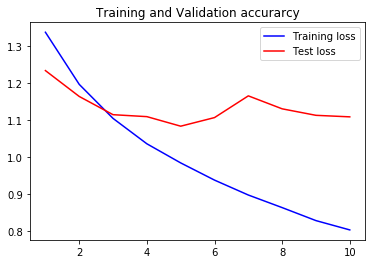

In [9]:
epoch=list(i for i in range(1,len(training_loss)+1))
plt.plot(epoch, training_loss, 'b', label='Training loss')
plt.plot(epoch, test_loss, 'r', label='Test loss')
plt.title('Training and Validation accurarcy')
plt.legend()

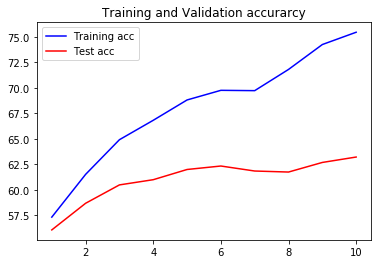

In [10]:
plt.plot(epoch, training_acc, 'b', label='Training acc')
plt.plot(epoch, test_acc, 'r', label='Test acc')
plt.title('Training and Validation accurarcy')
plt.legend()

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
test_acc=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    test_acc.append(100 * class_correct[i] / class_total[i])

Accuracy of plane : 56 %
Accuracy of   car : 83 %
Accuracy of  bird : 30 %
Accuracy of   cat : 34 %
Accuracy of  deer : 41 %
Accuracy of   dog : 54 %
Accuracy of  frog : 62 %
Accuracy of horse : 77 %
Accuracy of  ship : 76 %
Accuracy of truck : 66 %


In [44]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
train_acc=[]
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    train_acc.append(100 * class_correct[i] / class_total[i])

Accuracy of plane : 60 %
Accuracy of   car : 88 %
Accuracy of  bird : 36 %
Accuracy of   cat : 35 %
Accuracy of  deer : 48 %
Accuracy of   dog : 59 %
Accuracy of  frog : 64 %
Accuracy of horse : 81 %
Accuracy of  ship : 81 %
Accuracy of truck : 69 %


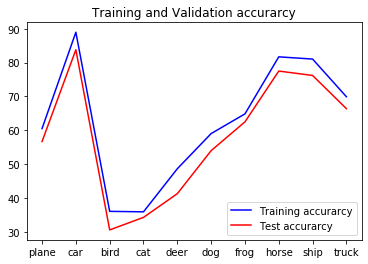

In [47]:
plt.plot(classes, train_acc, 'b', label='Training accurarcy')
plt.plot(classes, test_acc, 'r', label='Test accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()